## Supervised learning 

In this particular problem, it's very very important to have *ZERO False Negatives*. The metrics are:

Symbol  | Description              | Formula              | Comments
------- | ------------------------ | -------------------- |
$$TP$$  | True positives           |                      |
$$FP$$  | False positives          |                      |
$$TN$$  | True negatives           |                      |
$$FN$$  | False negatives          | Values classified negative, actually positive |
$$FPR$$ | False Positives Rate     | $${FP}/{(TN+FP)}$$ |
$$FNR$$ | **False Negatives Rate** | $${FN}/{(TP+FN)}$$ |Should be zero / near to zero
pre     | Precision                | $${FN}/{(TP+FN)}$$ |
sen     | **Sensitivity**          | $${TP}/{(TP+FN)}$$ | Its equal to $$1-FNR$$
spec    | Specificity              | $${TN}/{(TN+FP)}$$ |


In [36]:
import pandas as pd
from pandas import HDFStore
import matplotlib.pyplot as plt
from utils_preproc import *
from utils_ml import *

In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
base_dir = 'D://VBox/data/itm_ecuador/visualization/'
plots_dir = {2013 : base_dir+'Plots2013', 2014 : base_dir+'Plots2014'}

# Load events manual classification 
ev_class = pd.read_csv('D://phd/data/labels.csv')

# Load descriptors 
desc_file = 'D://phd/data/desc_layer_1.h5'
x, y = load_descriptors_layer_1(desc_file, ev_class=ev_class)

# The data preparation pipeline consists of:
# split_train_test -> class_balance -> scale -> pca_transform
x_train, x_test, y_train, y_test = pipeline(x, y)

train_target = y_train.valid_event
test_target = y_test.valid_event


Dataset size (8471, 55)
Train size:	 (5929, 55)
Test size:	 (2542, 55)
[0.25176702 0.49995112 0.57743039 0.6543221  0.69699928 0.73772787
 0.77230717 0.79474639 0.81583022 0.83526625 0.85236535 0.86764575
 0.88191762 0.89512687 0.90789351 0.91961202 0.9302904  0.94002034
 0.94907912 0.95566788 0.961365   0.9665484  0.97117384 0.97560852
 0.97950627 0.98283259 0.98567968 0.98790477 0.9899989  0.99141224
 0.99266823 0.99359598 0.99441066 0.99506131 0.995625   0.9961414
 0.99654127 0.99691611 0.99728329 0.99762539 0.99794091 0.99824155
 0.99850934 0.99875166 0.9989478  0.99912571 0.999278   0.99942053
 0.99955441 0.99966985 0.9997603  0.99984741 0.99991267 0.99997705
 1.        ]
Final datasets size:
Train size:	 (15032, 10)
Test size:	 (2542, 10)


In [39]:
def eval_model(x, y, model):

    y_pred = model.predict(x)
    print("Number of mislabeled points out of a total %d points : %d" % (x.shape[0],(y != y_pred).sum()))
    
    a = np.array(y,dtype="b")
    b = np.array(y_pred,dtype="b")
    
    cm = confusion_matrix(a,b,labels=[0,1])
    plot_confusion_matrix(cm, ["False","True"])
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print(confusion_matrix(y, y_pred))

    fpr = 100*fp/(tn+fp)
    fnr = 100*fn/(tp+fn)
    print('FPR: %.2f' % round(fpr, 1), 
          '\t FNR: %.2f' % round(fnr, 1))
    return


******* train *******
Number of mislabeled points out of a total 15032 points : 1070


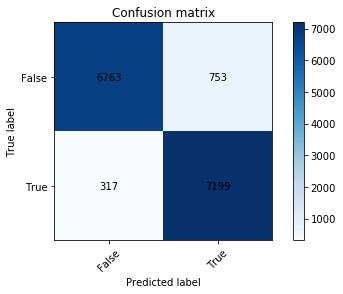

[[6763  753]
 [ 317 7199]]
FPR: 10.00 	 FNR: 4.20

******* test *******
Number of mislabeled points out of a total 2542 points : 232


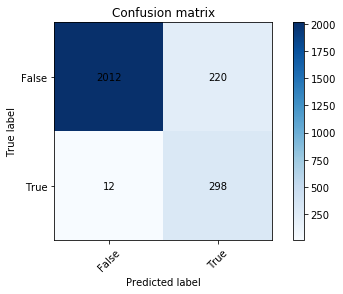

[[2012  220]
 [  12  298]]
FPR: 9.90 	 FNR: 3.90


In [40]:
### Naive bayes classifier
gnb = GaussianNB()
model = gnb.fit(x_train, train_target)
print("\n******* train *******")
eval_model(x_train, train_target, model)
print("\n******* test *******")
eval_model(x_test, test_target, model)



******* train *******
Number of mislabeled points out of a total 15032 points : 852


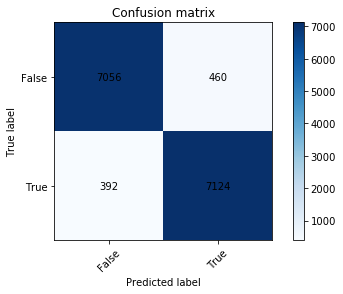

[[7056  460]
 [ 392 7124]]
FPR: 6.10 	 FNR: 5.20

******* test *******
Number of mislabeled points out of a total 2542 points : 136


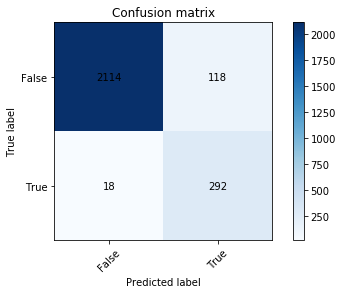

[[2114  118]
 [  18  292]]
FPR: 5.30 	 FNR: 5.80


In [15]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression()
model = lrc.fit(x_train, train_target)
print("\n******* train *******")
eval_model(x_train, train_target, model)
print("\n******* test *******")
eval_model(x_test, test_target, model)


******* train *******
Number of mislabeled points out of a total 15032 points : 7


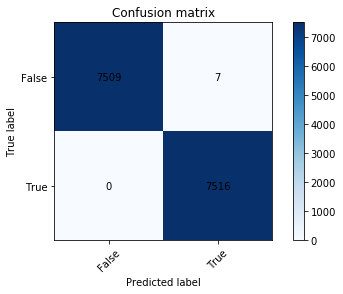

[[7509    7]
 [   0 7516]]
FPR: 0.10 	 FNR: 0.00

******* test *******
Number of mislabeled points out of a total 2542 points : 1


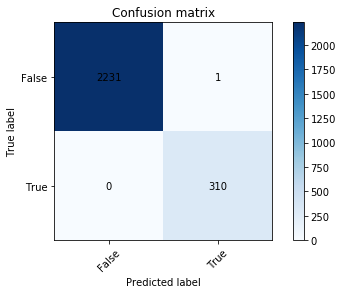

[[2231    1]
 [   0  310]]
FPR: 0.00 	 FNR: 0.00


In [51]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)#,random_state=1234)
model = rfc.fit(x_train, train_target)
print("\n******* train *******")
eval_model(x_train, train_target, model)
print("\n******* test *******")
eval_model(x_test, test_target, model)

## Models performance summary

| Model | Train FNR | Test FNR | Train FPR | Test FPR | Train Acc | Test Acc |  
|:-:|:-:    |
| Naive bayes | 5.70 | 8.40 | 12.80 | 12.60 | 0.91 | 0.88 |
| LogisticRegression | 5.20 | 5.80 | 6.10 | 5.30 | 0.94 | 0.94 |
| RandomForestClassifier | 0 | 0 | 0 | 0 | 1.00 | 1.00 |